Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression, SGDClassifier
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified .\notMNIST_large.tar.gz
Found and verified .\notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

.\notMNIST_large already present - Skipping extraction of .\notMNIST_large.tar.gz.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
.\notMNIST_small already present - Skipping extraction of .\notMNIST_small.tar.gz.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [4]:
display(Image(filename="notMNIST_small/A/Q0NXaWxkV29yZHMtQm9sZEl0YWxpYy50dGY=.png"))


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

.\notMNIST_large\A.pickle already present - Skipping pickling.
.\notMNIST_large\B.pickle already present - Skipping pickling.
.\notMNIST_large\C.pickle already present - Skipping pickling.
.\notMNIST_large\D.pickle already present - Skipping pickling.
.\notMNIST_large\E.pickle already present - Skipping pickling.
.\notMNIST_large\F.pickle already present - Skipping pickling.
.\notMNIST_large\G.pickle already present - Skipping pickling.
.\notMNIST_large\H.pickle already present - Skipping pickling.
.\notMNIST_large\I.pickle already present - Skipping pickling.
.\notMNIST_large\J.pickle already present - Skipping pickling.
.\notMNIST_small\A.pickle already present - Skipping pickling.
.\notMNIST_small\B.pickle already present - Skipping pickling.
.\notMNIST_small\C.pickle already present - Skipping pickling.
.\notMNIST_small\D.pickle already present - Skipping pickling.
.\notMNIST_small\E.pickle already present - Skipping pickling.
.\notMNIST_small\F.pickle already present - Skipping pi

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

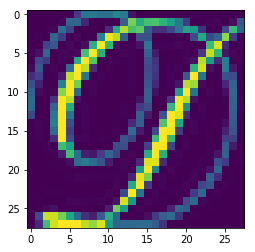

In [13]:
pickle_file = train_datasets[3] # index 3 is for D
with open(pickle_file, "rb") as f:
    letter_set = pickle.load(f) # unpickle
    sample_ind = np.random.randint(len(letter_set)) # pick a random index from 0 to letter_set-1
    sample_image = letter_set[sample_ind, :, :] # extract a 2D slice
    plt.figure()
    plt.imshow(sample_image)

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [6]:
"""
I don't really know what it means for the data to be "balanced" across classes.
This is what I thought would be right: 
    for each letter set (A through J):
        mean should be small (near 0)
        standard deviation should be uniform (nearly equal)
And that's what I tried to do.

I wrote a part of the code in a function and called it, as I may need to redo the task later in the program.
"""

def balance_check(dataset, name=None):
    print(f'Mean for letter {name}: {np.mean(dataset)}')
    print(f'SD for letter {name}: {np.std(dataset)} \n')

print("CHECKING TRAIN DATASET \n-----------------")
letters = "ABCDEFGHIJ"
for class_ind in range(num_classes):
    pickle_file = train_datasets[class_ind]
    with open(pickle_file, "rb") as f:
        letter_set = pickle.load(f)
        balance_check(letter_set, letters[class_ind])

CHECKING TRAIN DATASET 
-----------------
Mean for letter A: -0.12825024127960205
SD for letter A: 0.4431206285953522 

Mean for letter B: -0.00756303034722805
SD for letter B: 0.4544910490512848 

Mean for letter C: -0.14225810766220093
SD for letter C: 0.4398062527179718 

Mean for letter D: -0.05736779421567917
SD for letter D: 0.45564764738082886 

Mean for letter E: -0.06989899277687073
SD for letter E: 0.4529419541358948 

Mean for letter F: -0.12558330595493317
SD for letter F: 0.44708964228630066 

Mean for letter G: -0.09458135068416595
SD for letter G: 0.4462398290634155 

Mean for letter H: -0.06852205842733383
SD for letter H: 0.45423176884651184 

Mean for letter I: 0.03078624978661537
SD for letter I: 0.46889907121658325 

Mean for letter J: -0.1533583551645279
SD for letter J: 0.44365644454956055 



Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [17]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            

# These sizes work well with my computer; you may change them according to your computer memory
train_size = 200000
valid_size = 1000
test_size = 1000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (1000, 28, 28) (1000,)
Testing: (1000, 28, 28) (1000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [18]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [19]:
# I assume I should repeat the same process as in Problem 3 to check the validity of the data

balance_check(train_dataset, "Train Dataset")
balance_check(test_dataset, "Test Dataset")

Mean for letter Train Dataset: -0.08171843737363815
SD for letter Train Dataset: 0.4542232155799866 

Mean for letter Test Dataset: -0.07867617905139923
SD for letter Test Dataset: 0.4577752351760864 



Finally, let's save the data for later reuse:

In [20]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [21]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 634280506


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [22]:
overlaps = 0
for ind in range(test_size):
    for i in test_dataset[ind]:
        if i in train_dataset[ind] and i in valid_dataset[ind]:
            overlaps += 1
        
print(f'{overlaps} overlaps across train, test and validation sets.')

# Skipping the optional questions, at least for now

27806 overlaps across train, test and validation sets.


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [23]:
# Reshape the datasets into 2D arrays because that's what sklearn supports
nsamples, nx, ny = train_dataset.shape
train_dataset = train_dataset.reshape(nsamples, nx*ny)
nsamples, nx, ny = test_dataset.shape
test_dataset = test_dataset.reshape(nsamples, nx*ny)

In [28]:
# Prepare a basic model
model = SGDClassifier(verbose=1, loss='log', learning_rate='optimal', eta0=0.19)

In [29]:
# Train it with the train dataset and the labels
model.fit(train_dataset, train_labels)

-- Epoch 1
Norm: 27.66, NNZs: 784, Bias: -38.241151, T: 200000, Avg. loss: 1.683947
Total training time: 2.55 seconds.
-- Epoch 2
Norm: 10.25, NNZs: 784, Bias: -8.622305, T: 400000, Avg. loss: 0.959585
Total training time: 4.12 seconds.
-- Epoch 3
Norm: 6.05, NNZs: 784, Bias: -5.076129, T: 600000, Avg. loss: 0.682747
Total training time: 5.74 seconds.
-- Epoch 4
Norm: 5.19, NNZs: 784, Bias: -4.609994, T: 800000, Avg. loss: 0.540973
Total training time: 7.82 seconds.
-- Epoch 5
Norm: 4.93, NNZs: 784, Bias: -4.321424, T: 1000000, Avg. loss: 0.454929
Total training time: 9.52 seconds.
-- Epoch 1
Norm: 40.92, NNZs: 784, Bias: -56.355798, T: 200000, Avg. loss: 2.216900
Total training time: 1.52 seconds.
-- Epoch 2
Norm: 18.96, NNZs: 784, Bias: -19.639905, T: 400000, Avg. loss: 1.284165
Total training time: 3.32 seconds.
-- Epoch 3
Norm: 9.64, NNZs: 784, Bias: -8.475795, T: 600000, Avg. loss: 0.917392
Total training time: 5.04 seconds.
-- Epoch 4
Norm: 6.41, NNZs: 784, Bias: -5.866751, T: 80

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.19, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=1, warm_start=False)

In [30]:
# Test it with the test dataset
pred = model.predict(test_dataset)

In [31]:
# Compute the accuracy of the predicted model

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(pred,test_labels)

print(f'Accuracy of prediction: {accuracy}')

Accuracy of prediction: 0.88
